# H&M Personalized Fashion 2/2 - Recommendation system

---

## Introduction

In the 1st part of this project we've analyzed in depth the different available datasets. Now, in this second and final step we're going to build a product recommendations system based on data from previous transactions, by using the _LightFM_ python library.



In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808297 sha256=022bb7c28badeaea2b945f18452359bfff36fc21b6e3a3381c95adfff708788a
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import itertools
import pickle

import os
from scipy import sparse

from lightfm import LightFM

from lightfm.data import Dataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

pd.set_option('mode.chained_assignment', None)


RANDOM_STATE = 42
ENV = "COLAB"  # "LOCAL"  #


if ENV == "COLAB":
    from google.colab import drive
    drive.mount('/content/drive')
    dir_path = "drive/MyDrive/recomm/projet/"
else:
    dir_path = "../../../dataset/"


file_customers = "customers.csv"
file_articles = "articles.csv"
file_transactions = "transactions_train.csv"


df_customers = pd.read_csv(dir_path + file_customers)
df_articles = pd.read_csv(dir_path + file_articles)
df_transactions = pd.read_csv(dir_path + file_transactions)

Mounted at /content/drive


__What is LightFM?__

It's a hybrid matrix factorisation model representing users and items as linear combinations of their content features’ latent factors. The model seems to outperforms both collaborative and content-based models in cold-start or sparse interaction data scenarios (using both user and item metadata), and performs at least as well as a pure collaborative matrix factorisation model where interaction data is abundant.

In LightFM, like in a collaborative filtering model, users and items are represented as latent vectors (embeddings). However, just as in a CB model, these are entirely defined by functions (in this case, linear combinations) of embeddings of the content features that describe each product or user.

__How LightFM works?__

[The LightFM paper](https://arxiv.org/pdf/1507.08439.pdf) describes its inner working: a lightFM model learns embeddings (latent representations in a high-dimensional space) for users and items in a way that encodes user preferences over items. When multiplied together, these representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.


---
# Data Preparation

For recommendation models, we have to deal with sparse datasets. Here we're going to keep a subset as dense as possible, by keeping only one full year (2019) of transactions:

In [ ]:
assert df_articles.article_id.nunique() == df_articles.shape[0]


print(f"Nb of transactions before filtering: {df_transactions.shape[0]}")
df_transactions.t_dat = pd.to_datetime(df_transactions.t_dat, infer_datetime_format=True)
df = df_transactions[(df_transactions.t_dat.dt.year == 2019)] # & (df_transactions.t_dat.dt.month.isin([5, 6, 7]))] # DEBUG
print(f"Nb of transactions after filtering:  {df.shape[0]}")

df = df.merge(df_articles[["article_id", "index_group_name", "index_name", "section_name"]], on='article_id')

# del df_articles
# df = df.merge(df_customers, on='customer_id') # not needed
# del df_customers

f"Total Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"

Nb of transactions before filtering: 31788324
Nb of transactions after filtering:  5274015


'Total Memory Usage: 1870.28 MB'

We keep only customers with at least 10 transactions, and drop customers with more than 100 purchases (resellers):

In [ ]:
customers_count = df['customer_id'].value_counts()
customers_count[(customers_count > 10) & (customers_count < 50)].shape

(154282,)

We also filter customer_id aged above 38 as it seems to be one of the target of H&M according to our EDA:

In [ ]:
df_customers.customer_id.nunique(), df_customers[(df_customers.age > 16) & (df_customers.age < 38)].customer_id.nunique(),

(1371980, 803696)

In [ ]:
print(f"Nb of customers before filtering: {df.customer_id.nunique()} and nb_transactions {df.shape[0]}")

customers_count = df['customer_id'].value_counts()

# 1st selection based on the nb of transactions
customers_kept = customers_count[(customers_count > 10) & (customers_count < 100)].index.values
df = df[df.customer_id.isin(customers_kept)]

# 2nd selection based on the customers' ages
customers_kept = df_customers[(df_customers.age > 16) & (df_customers.age < 38)].customer_id.unique()
df = df[df.customer_id.isin(customers_kept)]

print(f"Nb of customers after filtering: {df.customer_id.nunique()} and nb_transactions {df.shape[0]}")

f"Total Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"

Nb of customers before filtering: 559625 and nb_transactions 5274015
Nb of customers after filtering: 99603 and nb_transactions 2127829


'Total Memory Usage: 754.88 MB'

For the sake of simplicity (and because training recommendation models on huge amount of data required many computation ressources), we're also going to keep only the main clothes' target: "Ladieswear"

<Axes: xlabel='count', ylabel='index_group_name'>

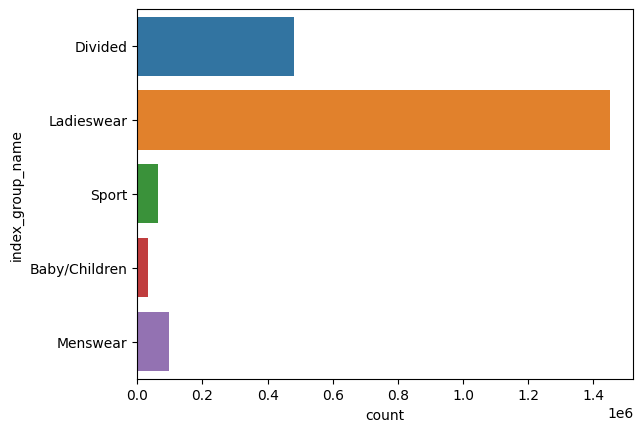

In [ ]:
sns.countplot(y=df["index_group_name"])

In [ ]:
df_temp = df.groupby(["index_group_name", "index_name"]).count()['t_dat'].reset_index().rename(columns={"t_dat": "count"})
px.bar(
    df_temp, x="count", y="index_group_name",
    color='index_name', barmode='group',
    width=700, height=400
).show()

![](02_img/02.png)

For now, we're not going to use the items features. Usually, the customers informations are more used for marketing purpose rather than features for the recommendation model. At the end, the dataset is only composed of `customer_id` & `article_id`, with many duplicated rows when items are purchased multiple times:

In [ ]:
df = df.loc[df.index_name == "Ladieswear"]

# if we want to restore the original dataset without loading it again
df_backup = df.copy()

df.drop(columns=[
    't_dat',
    'price',
    'sales_channel_id',
    'index_group_name',
    'index_name',
    'section_name'], inplace=True)

print(df.shape)
print(df.customer_id.nunique(), df.article_id.nunique())
df.head()

(837769, 2)
92444 10962


,customer_id,article_id
119,2d204c6e1ada9b80883dbb539a5048e72280289be7024f...,735404001
120,2f3d8fc02d513e39f120a142bf1f5004f08f726343b60a...,735404001
122,3550bfadda83a32d8e0526ca4d26f8bf9a391e2ea16bd5...,735404001
123,36ecdd962d8a50a0a12a65f1087457d2ac7757265dd199...,735404001
124,3d1231f8cfeb6390fb5379ae48a9a73095d2bc9fb22ab0...,735404001


## Feedback matrix

Firstly, we have to create lightFM `Dataset` for our model. LightFM `Dataset` class makes it really easy for us for creating `interection matrix`, `weights` and `user/item features`.

- `interection matrix`: It is a matrix that contains user/ item interections or professional/quesiton intereactions.
- `weights`: weight of interection matrix. Less weight means less importance to that interection matrix.
- `user/item features`: user/item features supplied as like this (user_id, ['feature_1', 'feature_2', 'feature_3'])

The `LightFM` libary can only be trained on sparse matrix: this is the types of dataset return by  the `build_interactions` method based on our initial dataset:

In [ ]:
dataset = Dataset()

# mapping creation
dataset.fit(
  users=df.customer_id.unique(),
  items=df.article_id.unique(),
  user_features=None,
  item_features=None
)

interactions, weights = dataset.build_interactions([(x[0], x[1]) for x in df.values])

int_dense = interactions.todense()
print(int_dense.shape)
int_dense

(92444, 10962)


matrix([[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

## Split dataset

Let's create separated train and test datasets:

In [ ]:
train, test = random_train_test_split(
  interactions = interactions,
  test_percentage = 0.2,
  random_state = np.random.RandomState(seed=RANDOM_STATE)
)
train.todense().shape, test.todense().shape

((92444, 10962), (92444, 10962))

---

# Recommendation systems

Recommender Systems are powerful, successful and widespread applications for almost every business selling products or services. It's especially useful for companies with a wide offer and diverse clients. Ideal examples are retail companies as well as these selling services or digital products.

You'll notice that after creating an account on Netflix or Spotify for example, the service will start to recommend you other products, movies or songs that the algorithm thinks will suit you the best. It's their way to personalise the offer and who doesn't like to get such care. That's why these systems are precious for business owners. The more you buy, watch and listen the better it gets. Also, the more users the better it gets.


Recommender Systems usually are classified into three groups:

- __Collaborative-filtering__:  

Collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person.

Though collaborative filtering One major problem of collaborative filtering is "cold start". As we’ve seen, collaborative-filtering can be a powerful way of recommending items based on user history, but what if there is no user history? This is called the “cold start” problem, and it can apply both to new items and to new users. Items with lots of history get recommended a lot, while those without never make it into the recommendation engine, resulting in a positive feedback loop. At the same time, new users have no history and thus the system doesn’t have any good recommendations. Potential solution: Onboarding processes can learn basic info to jump-start user preferences, importing social network contacts.


- __Content-based filtering__

These filtering methods are based on the description of an item and a profile of the user’s preferred choices. In a content-based recommendation system, keywords are used to describe the items; besides, a user profile is built to state the type of item this user likes. In other words, the algorithms try to recommend products which are similar to the ones that a user has liked in the past. The idea of content-based filtering is that if you like an item you will also like a ‘similar’ item. For example, when we are recommending the same kind of item like a movie or song recommendation.

One major problem of this approach is the diversity. Relevance is important, but it’s not all there is. If you watched and liked Star Wars, the odds are pretty good that you’ll also like The Empire Strikes Back, but you probably don’t need a recommendation engine to tell you that. It’s also important for a recommendation engine to come up with results that are novel (that is, stuff the user wasn’t expecting) and diverse (that is, stuff that represents a broad selection of their interests).

- __Hybrid recommender system__:

Hybrid recommender system is a special type of recommender system that combines both content and collaborative filtering method. Combining collaborative filtering and content-based filtering could be more effective in some cases. Hybrid approaches can be implemented in several ways: by making content-based and collaborative-based predictions separately and then combining them; by adding content-based capabilities to a collaborative-based approach (and vice versa). Several studies empirically compare the performance of the hybrid with pure collaborative and content-based methods and demonstrate that hybrid methods can provide more accurate recommendations than pure approaches. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

# Building models with LightFM

We start building our LightFM model using `LightFM` class. `LightFM` class makes it really easy for making lightFM model. After that we will fit our model on our train dataset.

## Baseline

In [ ]:
model = LightFM(
    no_components=50,
    learning_rate=0.05,
    loss='warp',
    random_state=RANDOM_STATE)


model.fit(
    train,
    item_features=None,
    user_features=None,
    sample_weight=None,
    epochs=5,
    num_threads=4,
    verbose=True
)

Epoch: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


## Evaluation

Evaluation metrics to consider:
- __AUC__ : It measure the ROC AUC metric for a model: the probability that a randomly chosen positive example has a higher score than a randomly chosen negative example. A perfect score is 1.0.
- __Precision at K__ : Measure the precision at k metric for a model: the fraction of known positives in the first k positions of the ranked list of results.A perfect score is 1.0.
- __Recall at K__ : Measure the recall at k metric for a model: the number of positive items in the first k positions of the ranked list of results divided by the number of positive items in the test period. A perfect score is 1.0.
- __Mean Reciprocal rank__ : Measure the reciprocal rank metric for a model: 1 / the rank of the highest ranked positive example. A perfect score is 1.0.

Here we're going to use the `preicision at k`:

In [ ]:
precision_train = precision_at_k(model, train, k=10, num_threads=4).mean()
precision_test = precision_at_k(model, test, k=10, num_threads=4).mean()
# recall_train = recall_at_k(model, train, k=10).mean()
# recall_test = recall_at_k(model, test, k=10).mean()

print(precision_train, precision_test)

0.17519069 0.024261154


## Hyperparameter Tuning using Random Search

Taken from [this blog post](https://www.kaggle.com/code/rickykonwar/h-m-lightfm-nofeatures-hyperparamter-tuning#Hyperparameter-Tuning-using-Random-Search) with adjustments to include or not the weights.

_Side note_: usually it's better to perfom hyperparameter tuning on a validation dataset using k-folds.

In [ ]:
def sample_hyperparameters():
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train_interactions, test_interactions, num_samples=50, num_threads=1, weights=None):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(
            interactions,
            item_features=None,
            user_features=None,
            sample_weight=weights,
            epochs=num_epochs,
            num_threads=num_threads,
            verbose=True
        )

        score = precision_at_k(
            model=model,
            test_interactions=test,
            train_interactions=None,
            k=10,
            num_threads=num_threads
        ).mean()
        weights_ = "No" if weights is None else "Yes"
        print(f"score: {score:.4f}, weights: {weights_}, hyperparams: {hyperparams}")
        hyperparams["num_epochs"] = num_epochs
        yield (score, hyperparams, model)


optimized_dict={}

score, hyperparams, model = max(random_search(
    train_interactions = train,
    test_interactions = test,
    num_threads = 4
    ), key=lambda x: x[0])


print(f"WITHOUT WEIGHTS: best score {score} obtained with the following hyper parameters {hyperparams}")

with open(dir_path + 'model_without_weights.pkl', 'wb') as f:
    pickle.dump(model, f)

Epoch: 100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


score: 0.1184, weights: No, hyperparams: {'no_components': 60, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.008489458350985983, 'item_alpha': 5.2786918388645496e-11, 'user_alpha': 3.5578101760199264e-08, 'max_sampled': 8}


Epoch: 100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


score: 0.0157, weights: No, hyperparams: {'no_components': 26, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.011351236451160842, 'item_alpha': 2.3757447922172716e-09, 'user_alpha': 2.576221612240835e-08, 'max_sampled': 8}


Epoch: 100%|██████████| 17/17 [00:37<00:00,  2.22s/it]


score: 0.0265, weights: No, hyperparams: {'no_components': 25, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.20268094162123085, 'item_alpha': 5.0002602107619414e-08, 'user_alpha': 7.214001271526802e-09, 'max_sampled': 5}


Epoch: 100%|██████████| 42/42 [01:45<00:00,  2.50s/it]


score: 0.0841, weights: No, hyperparams: {'no_components': 34, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.009476238615525146, 'item_alpha': 2.4683127619020046e-09, 'user_alpha': 1.5327249869954048e-08, 'max_sampled': 8}


Epoch: 100%|██████████| 33/33 [02:14<00:00,  4.07s/it]


score: 0.1178, weights: No, hyperparams: {'no_components': 63, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.07700164716232241, 'item_alpha': 1.4988370442402255e-08, 'user_alpha': 5.33774952182678e-10, 'max_sampled': 8}


Epoch: 100%|██████████| 29/29 [00:57<00:00,  1.98s/it]


score: 0.0796, weights: No, hyperparams: {'no_components': 44, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.02093385452546831, 'item_alpha': 2.728633791520588e-09, 'user_alpha': 3.1852815688131494e-09, 'max_sampled': 8}


Epoch: 100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


score: 0.0291, weights: No, hyperparams: {'no_components': 37, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.07337082308302029, 'item_alpha': 1.5818947289600787e-08, 'user_alpha': 1.8439206264133834e-09, 'max_sampled': 8}


Epoch: 100%|██████████| 28/28 [00:59<00:00,  2.11s/it]


score: 0.0702, weights: No, hyperparams: {'no_components': 27, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.03597621271177723, 'item_alpha': 1.066079111456357e-08, 'user_alpha': 1.4935275157239662e-09, 'max_sampled': 13}


Epoch: 100%|██████████| 7/7 [00:18<00:00,  2.69s/it]


score: 0.0785, weights: No, hyperparams: {'no_components': 56, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.043999094342271346, 'item_alpha': 4.011686265885717e-09, 'user_alpha': 2.4055523759404455e-08, 'max_sampled': 13}


Epoch: 100%|██████████| 21/21 [01:26<00:00,  4.10s/it]


score: 0.1111, weights: No, hyperparams: {'no_components': 63, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.02082976775237554, 'item_alpha': 5.7115082839828855e-09, 'user_alpha': 6.139919330512102e-09, 'max_sampled': 7}


Epoch: 100%|██████████| 17/17 [00:35<00:00,  2.09s/it]


score: 0.0389, weights: No, hyperparams: {'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.017981668831997283, 'item_alpha': 1.2267759710572198e-08, 'user_alpha': 4.433752560533984e-09, 'max_sampled': 7}


Epoch: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]


score: 0.0439, weights: No, hyperparams: {'no_components': 24, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.06530665788086394, 'item_alpha': 2.042868604306623e-10, 'user_alpha': 8.721969570495363e-10, 'max_sampled': 12}


Epoch: 100%|██████████| 47/47 [01:16<00:00,  1.63s/it]


score: 0.0146, weights: No, hyperparams: {'no_components': 26, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.006178506421929304, 'item_alpha': 2.7093875553940435e-09, 'user_alpha': 7.273904452198623e-09, 'max_sampled': 9}


Epoch: 100%|██████████| 42/42 [02:01<00:00,  2.90s/it]


score: 0.0205, weights: No, hyperparams: {'no_components': 32, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.0074020080229698845, 'item_alpha': 1.6349492215777502e-08, 'user_alpha': 1.02422214383447e-08, 'max_sampled': 13}


Epoch: 100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


score: 0.0205, weights: No, hyperparams: {'no_components': 17, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.027010776113746672, 'item_alpha': 5.105470894868097e-08, 'user_alpha': 7.731603792569205e-09, 'max_sampled': 8}


Epoch: 100%|██████████| 25/25 [01:09<00:00,  2.79s/it]


score: 0.0990, weights: No, hyperparams: {'no_components': 51, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.03180262694349833, 'item_alpha': 3.5661432441043654e-10, 'user_alpha': 6.225575876923253e-09, 'max_sampled': 13}


Epoch: 100%|██████████| 43/43 [01:18<00:00,  1.82s/it]


score: 0.0552, weights: No, hyperparams: {'no_components': 20, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.3975474502074487, 'item_alpha': 1.0085754345123819e-09, 'user_alpha': 1.674762229690028e-08, 'max_sampled': 9}


Epoch: 100%|██████████| 34/34 [00:56<00:00,  1.66s/it]


score: 0.0508, weights: No, hyperparams: {'no_components': 18, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.011756190055794575, 'item_alpha': 6.802436755169616e-09, 'user_alpha': 3.2965492281084603e-09, 'max_sampled': 14}


Epoch: 100%|██████████| 47/47 [01:07<00:00,  1.44s/it]


score: 0.0783, weights: No, hyperparams: {'no_components': 43, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.000367684459109206, 'item_alpha': 1.8460255529665282e-08, 'user_alpha': 1.149908583450629e-08, 'max_sampled': 5}


Epoch: 100%|██████████| 38/38 [01:17<00:00,  2.05s/it]


score: 0.0288, weights: No, hyperparams: {'no_components': 19, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.011788640941035024, 'item_alpha': 4.992940509408372e-09, 'user_alpha': 7.4499818317910785e-09, 'max_sampled': 10}


Epoch: 100%|██████████| 25/25 [00:45<00:00,  1.83s/it]


score: 0.0569, weights: No, hyperparams: {'no_components': 35, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.1960806849236641, 'item_alpha': 2.729351048022562e-09, 'user_alpha': 4.133409719598537e-09, 'max_sampled': 8}


Epoch: 100%|██████████| 26/26 [00:53<00:00,  2.04s/it]


score: 0.0643, weights: No, hyperparams: {'no_components': 24, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.002941058210785485, 'item_alpha': 5.1424901002772616e-09, 'user_alpha': 6.91845859499019e-09, 'max_sampled': 12}


Epoch: 100%|██████████| 26/26 [00:44<00:00,  1.70s/it]


score: 0.0589, weights: No, hyperparams: {'no_components': 38, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.04028909479752396, 'item_alpha': 1.1565718458711104e-09, 'user_alpha': 1.0009390198350543e-08, 'max_sampled': 6}


Epoch: 100%|██████████| 31/31 [00:41<00:00,  1.33s/it]


score: 0.0543, weights: No, hyperparams: {'no_components': 19, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.06767525362736307, 'item_alpha': 8.658555666446208e-09, 'user_alpha': 7.013437859707196e-10, 'max_sampled': 6}


Epoch: 100%|██████████| 21/21 [01:01<00:00,  2.94s/it]


score: 0.0332, weights: No, hyperparams: {'no_components': 57, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.010988180532655399, 'item_alpha': 8.941550820453398e-10, 'user_alpha': 2.2742367477549557e-09, 'max_sampled': 11}


Epoch: 100%|██████████| 18/18 [00:22<00:00,  1.27s/it]


score: 0.0222, weights: No, hyperparams: {'no_components': 16, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.028506554037759615, 'item_alpha': 9.641064126776272e-09, 'user_alpha': 8.833797166985893e-09, 'max_sampled': 7}


Epoch: 100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


score: 0.0868, weights: No, hyperparams: {'no_components': 48, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.049501963126291446, 'item_alpha': 1.24662402720029e-08, 'user_alpha': 2.918340879383955e-08, 'max_sampled': 10}


Epoch: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]


score: 0.0524, weights: No, hyperparams: {'no_components': 39, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.17338637553061645, 'item_alpha': 5.361543573115038e-10, 'user_alpha': 2.002298361675119e-08, 'max_sampled': 9}


Epoch: 100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


score: 0.0571, weights: No, hyperparams: {'no_components': 18, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.033715258632773686, 'item_alpha': 9.661102807501331e-09, 'user_alpha': 2.750677006669429e-08, 'max_sampled': 13}


Epoch: 100%|██████████| 41/41 [01:23<00:00,  2.03s/it]


score: 0.0804, weights: No, hyperparams: {'no_components': 39, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.05600737540741975, 'item_alpha': 1.8485276632808715e-08, 'user_alpha': 9.355103159961102e-09, 'max_sampled': 13}


Epoch: 100%|██████████| 37/37 [01:24<00:00,  2.27s/it]


score: 0.0097, weights: No, hyperparams: {'no_components': 40, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0023127792281584228, 'item_alpha': 2.3409776622448326e-08, 'user_alpha': 2.3858142209875898e-09, 'max_sampled': 14}


Epoch: 100%|██████████| 25/25 [01:40<00:00,  4.02s/it]


score: 0.1204, weights: No, hyperparams: {'no_components': 59, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.04678605722452761, 'item_alpha': 1.4568942464928752e-09, 'user_alpha': 7.034156593951941e-09, 'max_sampled': 12}


Epoch: 100%|██████████| 48/48 [02:06<00:00,  2.64s/it]


score: 0.0575, weights: No, hyperparams: {'no_components': 26, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.021252239959061937, 'item_alpha': 6.244245279241887e-10, 'user_alpha': 1.4361031087159242e-08, 'max_sampled': 14}


Epoch: 100%|██████████| 8/8 [00:21<00:00,  2.66s/it]


score: 0.0005, weights: No, hyperparams: {'no_components': 46, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.010318789212568248, 'item_alpha': 3.0111956076196613e-08, 'user_alpha': 9.576050274253258e-10, 'max_sampled': 8}


Epoch: 100%|██████████| 43/43 [01:31<00:00,  2.14s/it]


score: 0.0514, weights: No, hyperparams: {'no_components': 32, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.04142400647219585, 'item_alpha': 1.5396926314222453e-09, 'user_alpha': 2.6967612249516e-08, 'max_sampled': 6}


Epoch: 100%|██████████| 19/19 [01:13<00:00,  3.84s/it]


score: 0.1165, weights: No, hyperparams: {'no_components': 60, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.0037804229048839623, 'item_alpha': 8.70526002846185e-09, 'user_alpha': 6.381520640327444e-09, 'max_sampled': 8}


Epoch: 100%|██████████| 36/36 [01:50<00:00,  3.07s/it]


score: 0.1126, weights: No, hyperparams: {'no_components': 54, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.028537869239252434, 'item_alpha': 1.7436010104141686e-08, 'user_alpha': 7.4444487816226e-10, 'max_sampled': 5}


Epoch: 100%|██████████| 42/42 [02:18<00:00,  3.31s/it]


score: 0.1014, weights: No, hyperparams: {'no_components': 59, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.11012806210593083, 'item_alpha': 8.67404738761519e-09, 'user_alpha': 2.3526414929564014e-08, 'max_sampled': 7}


Epoch: 100%|██████████| 28/28 [00:50<00:00,  1.79s/it]


score: 0.0486, weights: No, hyperparams: {'no_components': 29, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.00040016513844334307, 'item_alpha': 1.7395271541570218e-09, 'user_alpha': 8.956763950941575e-09, 'max_sampled': 10}


Epoch: 100%|██████████| 37/37 [01:00<00:00,  1.64s/it]


score: 0.0200, weights: No, hyperparams: {'no_components': 24, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.007923905020468277, 'item_alpha': 4.379925484059337e-09, 'user_alpha': 1.810161517621402e-08, 'max_sampled': 9}


Epoch: 100%|██████████| 47/47 [01:08<00:00,  1.46s/it]


score: 0.0326, weights: No, hyperparams: {'no_components': 17, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.01696015491172653, 'item_alpha': 2.8278028058916933e-09, 'user_alpha': 2.222871134833341e-09, 'max_sampled': 14}


Epoch: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it]


score: 0.0269, weights: No, hyperparams: {'no_components': 19, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.01328570869143282, 'item_alpha': 1.4502387536330153e-09, 'user_alpha': 1.2930103536520046e-08, 'max_sampled': 10}


Epoch: 100%|██████████| 36/36 [01:22<00:00,  2.29s/it]


score: 0.0952, weights: No, hyperparams: {'no_components': 47, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.01580167442897965, 'item_alpha': 1.284790496180712e-08, 'user_alpha': 1.4253432684617029e-08, 'max_sampled': 11}


Epoch: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


score: 0.0611, weights: No, hyperparams: {'no_components': 33, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.05192392040043913, 'item_alpha': 1.367681818552861e-08, 'user_alpha': 9.866018299454185e-09, 'max_sampled': 8}


Epoch: 100%|██████████| 12/12 [00:17<00:00,  1.49s/it]


score: 0.0067, weights: No, hyperparams: {'no_components': 24, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0019944561997027647, 'item_alpha': 1.4626090289651365e-09, 'user_alpha': 1.2842632714070243e-09, 'max_sampled': 14}


Epoch: 100%|██████████| 11/11 [00:48<00:00,  4.44s/it]


score: 0.1054, weights: No, hyperparams: {'no_components': 62, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.05692364711871502, 'item_alpha': 4.371936480530466e-08, 'user_alpha': 7.005182120721418e-08, 'max_sampled': 10}


Epoch: 100%|██████████| 47/47 [01:15<00:00,  1.60s/it]


score: 0.0440, weights: No, hyperparams: {'no_components': 24, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.036711424130752124, 'item_alpha': 3.382855601751598e-09, 'user_alpha': 1.2413696831251556e-08, 'max_sampled': 10}


Epoch: 100%|██████████| 16/16 [00:23<00:00,  1.50s/it]


score: 0.0262, weights: No, hyperparams: {'no_components': 19, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.020669422965642843, 'item_alpha': 7.978835761698527e-09, 'user_alpha': 3.5784385315233315e-08, 'max_sampled': 8}


Epoch: 100%|██████████| 44/44 [02:46<00:00,  3.79s/it]


score: 0.1304, weights: No, hyperparams: {'no_components': 54, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.009802596101768535, 'item_alpha': 1.1405022588283016e-08, 'user_alpha': 1.1784362838916816e-08, 'max_sampled': 11}


Epoch: 100%|██████████| 43/43 [01:38<00:00,  2.30s/it]


score: 0.0916, weights: No, hyperparams: {'no_components': 46, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.030843895830248953, 'item_alpha': 8.392851304125428e-09, 'user_alpha': 1.0179184395176035e-08, 'max_sampled': 13}
WITHOUT WEIGHTS: best score 0.13038481771945953 obtained with the following hyper parameters {'no_components': 54, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.009802596101768535, 'item_alpha': 1.1405022588283016e-08, 'user_alpha': 1.1784362838916816e-08, 'max_sampled': 11, 'num_epochs': 44}


So, without considering the weights (i.e the number of times an itmen is bought by the same customer), the best precision score 0.13 on the test set, obtained with the following hyper parameters:
- no_components: 54
- learning_schedule: 'adadelta'
- learning_rate': 0.0098
- item_alpha: 1.14e-08
- user_alpha: 1.17e-08
- max_sampled': 11
- num_epochs: 44


## Using Weights

Let's try the same thing but this time with the weights:

In [ ]:
# overriden because the k-OS loss with sample weights is not implemented.
def sample_hyperparameters():
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp"]), #, "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }

score_w, hyperparams_w, model_w = max(random_search(
    train_interactions = train,
    test_interactions = test,
    num_threads = 4,
    weights=weights,
    ), key=lambda x: x[0])


print(f"WITH WEIGHTS: best score {score_w} obtained with the following hyper parameters {hyperparams_w}")

with open(dir_path + 'model_with_weights.pkl', 'wb') as f:
    pickle.dump(model_w, f)

Epoch: 100%|██████████| 21/21 [00:36<00:00,  1.74s/it]


score: 0.0658, weights: Yes, hyperparams: {'no_components': 35, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.03793522958313662, 'item_alpha': 1.526228884795337e-09, 'user_alpha': 1.4820473052576738e-08, 'max_sampled': 10}


Epoch: 100%|██████████| 41/41 [00:59<00:00,  1.44s/it]


score: 0.0558, weights: Yes, hyperparams: {'no_components': 35, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.020399551978036737, 'item_alpha': 2.462376731983936e-08, 'user_alpha': 4.266936687426811e-09, 'max_sampled': 6}


Epoch: 100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


score: 0.0069, weights: Yes, hyperparams: {'no_components': 41, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.002104353773814272, 'item_alpha': 3.6025295671329667e-09, 'user_alpha': 6.0766137429503265e-09, 'max_sampled': 5}


Epoch: 100%|██████████| 36/36 [01:24<00:00,  2.35s/it]


score: 0.0095, weights: Yes, hyperparams: {'no_components': 48, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0019971101932895934, 'item_alpha': 2.815074994031493e-09, 'user_alpha': 8.650914137082252e-09, 'max_sampled': 5}


Epoch: 100%|██████████| 49/49 [00:50<00:00,  1.02s/it]


score: 0.0327, weights: Yes, hyperparams: {'no_components': 17, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.05501822703716212, 'item_alpha': 2.0205311858260595e-08, 'user_alpha': 2.6899753042320347e-08, 'max_sampled': 9}


Epoch: 100%|██████████| 19/19 [00:44<00:00,  2.34s/it]


score: 0.0949, weights: Yes, hyperparams: {'no_components': 49, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.17346429466606517, 'item_alpha': 1.7222663479166887e-09, 'user_alpha': 3.7845045644110775e-09, 'max_sampled': 9}


Epoch: 100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


score: 0.0373, weights: Yes, hyperparams: {'no_components': 46, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.14176439488097178, 'item_alpha': 8.91159271963858e-09, 'user_alpha': 1.922607726353105e-08, 'max_sampled': 12}


Epoch: 100%|██████████| 47/47 [01:55<00:00,  2.46s/it]


score: 0.1099, weights: Yes, hyperparams: {'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.14142478782518758, 'item_alpha': 3.1028080719959846e-09, 'user_alpha': 2.3544746099355193e-08, 'max_sampled': 5}


Epoch: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


score: 0.0473, weights: Yes, hyperparams: {'no_components': 32, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.018556703955401207, 'item_alpha': 5.212407241109214e-10, 'user_alpha': 1.2541647844199964e-08, 'max_sampled': 8}


Epoch: 100%|██████████| 21/21 [00:33<00:00,  1.61s/it]


score: 0.0370, weights: Yes, hyperparams: {'no_components': 26, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.049541236674743874, 'item_alpha': 3.522027756658201e-09, 'user_alpha': 1.2681393416414088e-08, 'max_sampled': 8}


Epoch: 100%|██████████| 21/21 [00:59<00:00,  2.82s/it]


score: 0.0932, weights: Yes, hyperparams: {'no_components': 50, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.03387174384864523, 'item_alpha': 7.893358237377167e-09, 'user_alpha': 1.593597171727312e-08, 'max_sampled': 13}


Epoch: 100%|██████████| 16/16 [00:37<00:00,  2.32s/it]


score: 0.0810, weights: Yes, hyperparams: {'no_components': 58, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.07868117489495788, 'item_alpha': 3.937895264063402e-09, 'user_alpha': 2.2174676170607094e-08, 'max_sampled': 6}


Epoch: 100%|██████████| 48/48 [02:56<00:00,  3.67s/it]


score: 0.1098, weights: Yes, hyperparams: {'no_components': 51, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.10704811452331975, 'item_alpha': 1.0081488780673856e-09, 'user_alpha': 3.8146715051638264e-09, 'max_sampled': 13}


Epoch: 100%|██████████| 48/48 [01:55<00:00,  2.40s/it]


score: 0.0736, weights: Yes, hyperparams: {'no_components': 49, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.014677674492214075, 'item_alpha': 1.9554026053618085e-08, 'user_alpha': 9.296314739916858e-09, 'max_sampled': 5}


Epoch: 100%|██████████| 47/47 [02:08<00:00,  2.74s/it]


score: 0.0157, weights: Yes, hyperparams: {'no_components': 58, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.0030724116757849186, 'item_alpha': 4.5689468573887534e-09, 'user_alpha': 4.574379171263984e-09, 'max_sampled': 8}


Epoch: 100%|██████████| 38/38 [01:46<00:00,  2.81s/it]


score: 0.0732, weights: Yes, hyperparams: {'no_components': 61, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.016433694130278214, 'item_alpha': 2.890971089054058e-09, 'user_alpha': 7.869346086403993e-09, 'max_sampled': 11}


Epoch: 100%|██████████| 44/44 [01:26<00:00,  1.96s/it]


score: 0.0812, weights: Yes, hyperparams: {'no_components': 37, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.026235152096036725, 'item_alpha': 6.576589179587815e-10, 'user_alpha': 1.045729436318275e-08, 'max_sampled': 7}


Epoch: 100%|██████████| 30/30 [01:55<00:00,  3.85s/it]


score: 0.1098, weights: Yes, hyperparams: {'no_components': 56, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.04007488026022399, 'item_alpha': 1.7269251666407176e-08, 'user_alpha': 1.2230320540668323e-09, 'max_sampled': 11}


Epoch: 100%|██████████| 16/16 [00:43<00:00,  2.73s/it]


score: 0.0740, weights: Yes, hyperparams: {'no_components': 44, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.01823859571005929, 'item_alpha': 2.861642354229063e-08, 'user_alpha': 1.8033008199604706e-08, 'max_sampled': 13}


Epoch: 100%|██████████| 40/40 [01:29<00:00,  2.25s/it]


score: 0.1171, weights: Yes, hyperparams: {'no_components': 59, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.012665602848716227, 'item_alpha': 1.4935650916004388e-08, 'user_alpha': 2.8019417042636662e-08, 'max_sampled': 9}


Epoch: 100%|██████████| 44/44 [01:17<00:00,  1.76s/it]


score: 0.0558, weights: Yes, hyperparams: {'no_components': 20, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.017667332156129163, 'item_alpha': 2.4322703456565893e-08, 'user_alpha': 6.9967521808441e-09, 'max_sampled': 13}


Epoch: 100%|██████████| 15/15 [00:39<00:00,  2.60s/it]


score: 0.0621, weights: Yes, hyperparams: {'no_components': 38, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.006943670820130927, 'item_alpha': 2.398276479192375e-08, 'user_alpha': 5.769636345064412e-08, 'max_sampled': 13}


Epoch: 100%|██████████| 17/17 [00:37<00:00,  2.21s/it]


score: 0.0760, weights: Yes, hyperparams: {'no_components': 45, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.040846750585832516, 'item_alpha': 1.665359694869504e-08, 'user_alpha': 8.994523811938608e-09, 'max_sampled': 11}


Epoch: 100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


score: 0.0634, weights: Yes, hyperparams: {'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.023946217501652503, 'item_alpha': 5.926469842525869e-09, 'user_alpha': 1.799730886757055e-08, 'max_sampled': 12}


Epoch: 100%|██████████| 33/33 [01:00<00:00,  1.82s/it]


score: 0.0580, weights: Yes, hyperparams: {'no_components': 21, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.03936365993934935, 'item_alpha': 9.097955643731656e-09, 'user_alpha': 4.81678005605124e-09, 'max_sampled': 9}


Epoch: 100%|██████████| 34/34 [00:58<00:00,  1.72s/it]


score: 0.0534, weights: Yes, hyperparams: {'no_components': 19, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.06925832437767236, 'item_alpha': 2.27499813697374e-09, 'user_alpha': 2.0723380324789156e-09, 'max_sampled': 5}


Epoch: 100%|██████████| 31/31 [01:03<00:00,  2.05s/it]


score: 0.1059, weights: Yes, hyperparams: {'no_components': 60, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.03551213744480774, 'item_alpha': 1.4061429382379768e-09, 'user_alpha': 3.424510308837215e-09, 'max_sampled': 6}


Epoch: 100%|██████████| 21/21 [00:46<00:00,  2.23s/it]


score: 0.0943, weights: Yes, hyperparams: {'no_components': 47, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.13556522915826605, 'item_alpha': 2.222058974113094e-09, 'user_alpha': 7.310174723622716e-09, 'max_sampled': 6}


Epoch: 100%|██████████| 15/15 [00:27<00:00,  1.83s/it]


score: 0.0735, weights: Yes, hyperparams: {'no_components': 33, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.1261768579034512, 'item_alpha': 1.3727776142168785e-08, 'user_alpha': 1.7844306101712864e-08, 'max_sampled': 9}


Epoch: 100%|██████████| 41/41 [00:50<00:00,  1.23s/it]


score: 0.0293, weights: Yes, hyperparams: {'no_components': 17, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.10553022329005904, 'item_alpha': 1.2315834910488261e-08, 'user_alpha': 1.3517784554903053e-08, 'max_sampled': 10}


Epoch: 100%|██████████| 20/20 [00:48<00:00,  2.45s/it]


score: 0.0908, weights: Yes, hyperparams: {'no_components': 50, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.03871698775019943, 'item_alpha': 1.104118895398419e-08, 'user_alpha': 7.842028688965213e-09, 'max_sampled': 12}


Epoch: 100%|██████████| 38/38 [01:02<00:00,  1.64s/it]


score: 0.0613, weights: Yes, hyperparams: {'no_components': 33, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.022144144928725677, 'item_alpha': 2.1034589020273705e-08, 'user_alpha': 1.8708745299842742e-08, 'max_sampled': 9}


Epoch: 100%|██████████| 31/31 [01:07<00:00,  2.19s/it]


score: 0.0057, weights: Yes, hyperparams: {'no_components': 45, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.001501128108060794, 'item_alpha': 1.2474114996964376e-08, 'user_alpha': 3.794024234371819e-09, 'max_sampled': 7}


Epoch: 100%|██████████| 13/13 [00:42<00:00,  3.25s/it]


score: 0.0897, weights: Yes, hyperparams: {'no_components': 46, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.011073842897468707, 'item_alpha': 2.005208440532375e-09, 'user_alpha': 9.53462103519007e-10, 'max_sampled': 10}


Epoch: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


score: 0.1019, weights: Yes, hyperparams: {'no_components': 47, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.027657351191754633, 'item_alpha': 1.4314364097095035e-08, 'user_alpha': 4.256906919418039e-09, 'max_sampled': 14}


Epoch: 100%|██████████| 9/9 [00:20<00:00,  2.23s/it]


score: 0.0796, weights: Yes, hyperparams: {'no_components': 45, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.10077482313945002, 'item_alpha': 4.981438616941746e-09, 'user_alpha': 1.8365630569487592e-08, 'max_sampled': 11}


Epoch: 100%|██████████| 22/22 [01:27<00:00,  3.97s/it]


score: 0.1078, weights: Yes, hyperparams: {'no_components': 57, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.037346373518231016, 'item_alpha': 1.2564031525427409e-08, 'user_alpha': 2.1821163690985893e-08, 'max_sampled': 9}


Epoch: 100%|██████████| 48/48 [00:41<00:00,  1.14it/s]


score: 0.0323, weights: Yes, hyperparams: {'no_components': 17, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.04103960468332536, 'item_alpha': 9.806799989200026e-09, 'user_alpha': 8.691586720449741e-09, 'max_sampled': 5}


Epoch: 100%|██████████| 22/22 [00:59<00:00,  2.70s/it]


score: 0.0996, weights: Yes, hyperparams: {'no_components': 54, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.010421315561846136, 'item_alpha': 4.575984004695092e-11, 'user_alpha': 1.3233880464405404e-09, 'max_sampled': 11}


Epoch: 100%|██████████| 31/31 [01:26<00:00,  2.79s/it]


score: 0.1141, weights: Yes, hyperparams: {'no_components': 59, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.11863440566479466, 'item_alpha': 2.70168016562207e-08, 'user_alpha': 5.505281964354219e-08, 'max_sampled': 6}


Epoch: 100%|██████████| 41/41 [01:40<00:00,  2.44s/it]


score: 0.1159, weights: Yes, hyperparams: {'no_components': 56, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.006613814359160146, 'item_alpha': 1.31858480762214e-08, 'user_alpha': 7.104013284626021e-10, 'max_sampled': 11}


Epoch: 100%|██████████| 16/16 [00:29<00:00,  1.82s/it]


score: 0.0395, weights: Yes, hyperparams: {'no_components': 27, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.006092493491719104, 'item_alpha': 5.364889912324228e-09, 'user_alpha': 1.7476899204887372e-09, 'max_sampled': 10}


Epoch: 100%|██████████| 33/33 [00:53<00:00,  1.61s/it]


score: 0.0814, weights: Yes, hyperparams: {'no_components': 48, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.06200462112113747, 'item_alpha': 1.1979152693443656e-08, 'user_alpha': 1.795516520541985e-09, 'max_sampled': 5}


Epoch: 100%|██████████| 14/14 [00:40<00:00,  2.89s/it]


score: 0.0839, weights: Yes, hyperparams: {'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.027296578148904578, 'item_alpha': 3.6293480891362386e-09, 'user_alpha': 3.812856408230529e-08, 'max_sampled': 6}


Epoch: 100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


score: 0.0907, weights: Yes, hyperparams: {'no_components': 44, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.12987122933746273, 'item_alpha': 7.365316592227551e-09, 'user_alpha': 4.692408418499562e-09, 'max_sampled': 13}


Epoch: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


score: 0.0379, weights: Yes, hyperparams: {'no_components': 34, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.0760019054502249, 'item_alpha': 6.13525105995698e-09, 'user_alpha': 5.107707398838067e-09, 'max_sampled': 14}


Epoch: 100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


score: 0.1059, weights: Yes, hyperparams: {'no_components': 57, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.0002606487991097935, 'item_alpha': 3.6504178025358686e-09, 'user_alpha': 1.519990865950949e-08, 'max_sampled': 12}


Epoch: 100%|██████████| 34/34 [02:26<00:00,  4.31s/it]


score: 0.1172, weights: Yes, hyperparams: {'no_components': 62, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.005779964110324431, 'item_alpha': 5.8232841799619904e-09, 'user_alpha': 1.7112869692085306e-09, 'max_sampled': 10}


Epoch: 100%|██████████| 27/27 [00:47<00:00,  1.74s/it]


score: 0.0537, weights: Yes, hyperparams: {'no_components': 19, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.08636897698001998, 'item_alpha': 4.230409864246658e-10, 'user_alpha': 3.649947540870082e-08, 'max_sampled': 7}


Epoch: 100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


score: 0.0630, weights: Yes, hyperparams: {'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.03273940087847153, 'item_alpha': 3.791919344957527e-09, 'user_alpha': 2.02930754839095e-08, 'max_sampled': 14}
WITH WEIGHTS: best score 0.11721404641866684 obtained with the following hyper parameters {'no_components': 62, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.005779964110324431, 'item_alpha': 5.8232841799619904e-09, 'user_alpha': 1.7112869692085306e-09, 'max_sampled': 10, 'num_epochs': 34}


The best precision score on the test set is 0.117, which unfortunately not better.

## Predictions

To get recommendation for a particular customer, we can use the `predict` method and the different `mappings`, that way we can also have the score :

In [ ]:
user_id_mapping, user_feature_mapping, item_id_mapping, item_feature_mapping = dataset.mapping()
n_users, n_items = df.customer_id.nunique(), df.article_id.nunique()


def get_top_k_recommendations_with_scores(customer_id, k=10):
  item_id_mapping_reverse = {v:k for k, v in item_id_mapping.items()}

  # the top recommendation is the item with the highest predict score, not the lowest.
  recommendation_scores_for_pairs = model.predict(user_id_mapping[customer_id], np.arange(n_items))
  recommendations = pd.DataFrame({"scores": recommendation_scores_for_pairs})
  recommendations["article_id"] = pd.Series(recommendations.index.values).apply(lambda x: item_id_mapping_reverse[x])
  recommendations = recommendations.merge(df_articles[["article_id", "prod_name", "product_type_name"]], on="article_id")

  display(recommendations.sort_values(by="scores", ascending=False).head(k))


get_top_k_recommendations_with_scores('c88e095d490d67ba66f57132759057247040570935ba21a447e64b782d20880c')

,scores,article_id,prod_name,product_type_name
7660,2.849209,752981001,Sara single,T-shirt
728,2.624799,433444001,Sara s/s 2-pack,T-shirt
4416,2.557556,300024013,Superskinny,Trousers
2755,2.545403,510465001,Moa 2-pack,Vest top
966,2.459155,262277011,Kim superskinny low waist,Trousers
1770,2.458308,590071010,Mika SS,T-shirt
2075,2.447792,469562002,Skinny denim (1),Trousers
4937,2.422281,510074015,Barza,Trousers
3070,2.410026,691479002,Love shorts,Shorts
1981,2.409466,433444017,Sara s/s 2-pack,T-shirt


It also is possible to use the `predict_rank` method on a whole dataset:

In [ ]:
ranks = model.predict_rank(
    test_interactions=test,
    train_interactions=None,
    item_features=None,
    user_features=None,
    num_threads=4,
    check_intersections=True
)

ranks_dense = ranks.todense()
assert ranks_dense.shape == (df.customer_id.nunique(), df.article_id.nunique())

---

# References:

- [The LightFM paper](https://arxiv.org/pdf/1507.08439.pdf)
- [LightFM Hybrid Recommendation system
](https://www.kaggle.com/code/niyamatalmass/lightfm-hybrid-recommendation-system#Model-in-Production)
- [The LightFM online documentation](https://making.lyst.com/lightfm/docs/lightfm.html?highlight=predict#lightfm.LightFM.predict)